In [387]:
# import library
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
mpl.style.use('ggplot') # for ggplot-like style
%matplotlib inline

# 1)Data visualizzation

**1.1)Loading and Visualizing Data**

In [388]:
df = pd.read_csv('../waterdug.csv', header=None)
#Adding header
headers = ['x','y']
df.columns = headers
df.head()

,x,y
0,-15.937,2.1343
1,-29.153,1.1733
2,36.190,34.3590
3,37.492,36.8380
4,-48.059,2.8090


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       54 non-null     float64
 1   y       54 non-null     float64
dtypes: float64(2)
memory usage: 992.0 bytes


**1.2)Split the data in Train, Cross Validation and Test set**

In [390]:
df_train = df.loc[0:11].copy()
df_train.shape

(12, 2)

In [391]:
df_cv = df.loc[12:32].copy()
df_cv.shape

(21, 2)

In [392]:
df_test = df.loc[33:].copy()
df_test.shape

(21, 2)

**1.3)Plot the data**

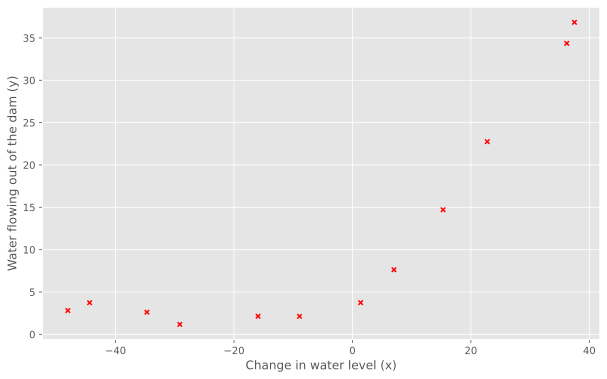

In [393]:
df_train.plot(kind='scatter', x='x', y='y', figsize=(10, 6), marker='x', color='red')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

# 2)Model selection

## 2.1)Training

**2.1.1)Define Features Normalize function**

In [394]:
def featureNormalize(X):
    #FEATURENORMALIZE return a normalized (X_norm) version of X
    X_norm = np.copy(X)
    r = X.shape[0]
    c = X.shape[1]
    mu = np.mean(X,0)
    sigma = np.std(X,0)
    for i in range(0, c):
        X_norm[:,i] = (X[:,i] - mu[i]) / sigma[i]
    return X_norm, mu, sigma

In [395]:
m_train = df_train.shape[0]
n = df_train.shape[1]-1
y = np.copy(df_train['y']).reshape(m_train, n) 
Xorig = np.copy(df_train['x']).reshape(m_train, n) 
result = featureNormalize(Xorig)
Xorig_norm = result[0]
mu = result[1]
sigma = result[2]
x0 = np.ones((m_train,1))
X = np.hstack((x0,Xorig_norm))
X

array([[ 1.        , -0.37825174],
       [ 1.        , -0.83891883],
       [ 1.        ,  1.43872718],
       [ 1.        ,  1.48411069],
       [ 1.        , -1.49792094],
       [ 1.        , -0.1344112 ],
       [ 1.        ,  0.71084808],
       [ 1.        , -1.03247848],
       [ 1.        ,  0.22568365],
       [ 1.        , -1.36982231],
       [ 1.        ,  0.42172859],
       [ 1.        ,  0.97070531]])

**2.1.1)Define Cost Function**

In [396]:
def costFunction(X, y, theta, l):
    #costFuntion for linear regression
    m = y.shape[0]
    h = np.dot(X,theta)
    squaredErrors = np.power(h-y,2)
    thetaExcludingZero = np.copy(theta)
    thetaExcludingZero[0] = 0 #set theta0 to 0 in order to exclude theta0 from regularization
    J = (1 / (2 * m)) * np.sum(squaredErrors) + (l/(2*m)) * np.sum(np.power(thetaExcludingZero,2))
    return J

**2.1.2)Define Gradient Descent function**

In [397]:
def gradientDescent(X, y, alpha, l, theta, numIters):
    #Train a linear regression model whit Gradient Descent
    m = y.shape[0]
    J_history = np.zeros((numIters,1))
    theta_history = np.zeros((numIters,theta.shape[0]))
    for i in range(0, numIters):
        h = X @ theta
        derTheta = (alpha/m) * (np.transpose(X) @ (h-y))
        theta[0] = theta[0] - derTheta[0] #excluding theta0 from regularization
        theta[1:] = theta[1:] * (1 - alpha * (l/m)) - derTheta[1:]
        J_history[i,0] = costFunction(X, y, theta, l)
        theta_history[i,:] = np.transpose(theta)
    return theta, J_history, theta_history

**2.1.3)Train**

In [398]:
#Learning parameters
alpha = 0.001
iterations = 1000
l = 0 #regularizzation parameter lambda
initial_theta = np.zeros((n+1,1))
result = gradientDescent(X, y, alpha, l, initial_theta, iterations)
theta = result[0]
J_history = result[1]
theta_history = result[2]
theta

array([[7.09290292],
       [6.67147948]])

**2.1.4)Plot Cost Function convergence graph**

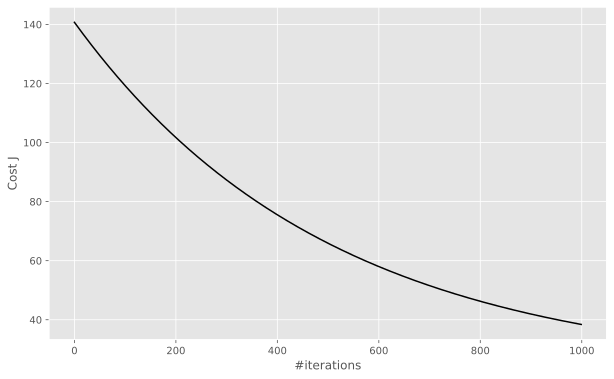

In [399]:
plt.figure(figsize=(10, 6))
plt.plot(J_history, color='black')
plt.xlabel('#iterations')
plt.ylabel('Cost J')
plt.show()

**2.1.5)Automatic selection of alpha**

In [400]:
def testConvergence(values):
    dim = np.max(values.shape)
    for i in range(1,dim):
        if values[i] >= values[i-1]:
            test = 0
            return test
    test = 1
    return test

In [401]:
def plotAlphaConvergence(iterations, different_alpha, alpha_possible, X, y, l):
    m = X.shape[0]
    n = X.shape[1]

    for i in range(1,different_alpha):
        alpha_possible[i] = alpha_possible[i-1]*1.3; 

    cost_function_alpha = np.zeros((iterations,different_alpha))
    convergenceTest = np.zeros((different_alpha,1))

    for i in range(0,different_alpha):
        theta_inner = np.zeros((n,1))
        alpha_val = alpha_possible[i]
        result = gradientDescent(X, y, alpha_val, l, theta_inner, iterations)
        theta = result[0]
        cost_function_alpha[:,i] = result[1].reshape(1,-1)
        cost_val = cost_function_alpha[:,i]
        convergenceTest[i] = testConvergence(cost_val)
    
    #Plot convergence graph
    plt.figure(figsize=(10, 6))
    plt.xlabel('#iterations')
    plt.ylabel('Cost J')
    for i in range(0,different_alpha):
        if convergenceTest[i] == 1:
            alpha_label = str(alpha_possible[i])
            plt.plot(np.arange(1,np.prod(cost_function_alpha[:,i].shape)+1),cost_function_alpha[:,i], label=alpha_label)
    plt.legend()
    plt.show()
    return convergenceTest, alpha_possible

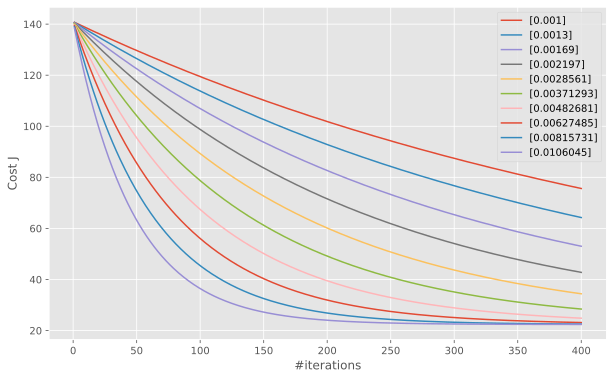

Alpha opt: 
 [[0.001     ]
 [0.0013    ]
 [0.00169   ]
 [0.002197  ]
 [0.0028561 ]
 [0.00371293]
 [0.00482681]
 [0.00627485]
 [0.00815731]
 [0.0106045 ]]
Best alpha:  [0.0106045]


In [402]:
iterations = 400
l = 0
different_alpha = 10
alpha_possible = np.zeros((different_alpha,1))
alpha_possible[0] = 0.001
result = plotAlphaConvergence(iterations, different_alpha, alpha_possible, X, y, l)
convergenceTest = result[0]
alpha_possible = result[1]
alpha_convergence = convergenceTest*alpha_possible
alpha_convergence = alpha_convergence[alpha_convergence != 0]
alpha_valid = np.copy(alpha_convergence).reshape(-1,1)
print('Alpha opt: \n', alpha_valid)
alpha = alpha_valid[-1]
print('Best alpha: ', alpha)

Plot convergence graph

**2.1.5)Plot fit over the data**

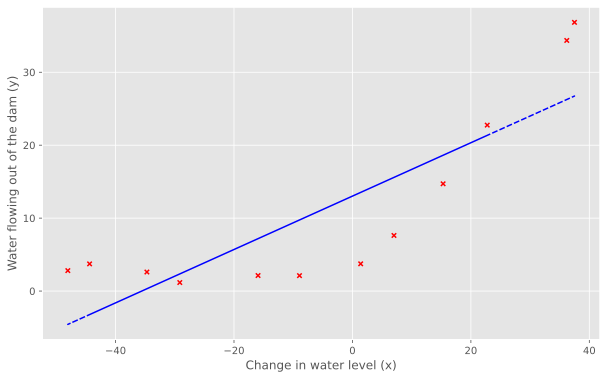

tetha found:
 [[11.15955097]
 [10.49650843]]


In [403]:
result = gradientDescent(X, y, alpha, l, initial_theta, iterations)
theta = result[0]
h = X @ theta
df_train.plot(kind='scatter', x='x', y='y', figsize=(10, 6), marker='x', color='red')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(Xorig , h, linestyle='--', color='blue')
plt.show()
print('tetha found:\n',theta)

## 2.2)Learning curves

In [404]:
m_cv = df_cv.shape[0]
n = df_cv.shape[1]-1
yval = np.copy(df_cv['y']).reshape(m_cv, n) 
XvalOrig = np.copy(df_cv['x']).reshape(m_cv, n) 
XvalOrig_norm = np.copy(XvalOrig)
XvalOrig_norm = XvalOrig_norm - mu
XvalOrig_norm = XvalOrig_norm / sigma
x0 = np.ones((m_cv,n))
Xval = np.hstack((x0,XvalOrig_norm))

**2.2.1)Define Learning Curve function**

In [405]:
def learningCurve(X, y, Xval, yval, alpha, l, iterations, plotChart):
    m = X.shape[0]
    n = X.shape[1]
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    for i in range(0, m):
        XSubset = np.copy(X[0:i+1, :]).reshape(i+1, n)
        ySubset = np.copy(y[0:i+1]).reshape(i+1,1)
        initial_theta = np.zeros((n,1)) 
        result = gradientDescent(XSubset, ySubset, alpha, l, initial_theta, iterations)
        theta = result[0]
        error_train[i] = costFunction(XSubset, ySubset, theta, l)
        error_val[i] = costFunction(Xval, yval, theta, l)
    
    if plotChart == 1:
        plt.figure(figsize=(10, 6))
        plt.title('Learning curve')
        plt.plot(error_train, label='Train', color='blue')
        plt.plot(error_val, label='Cross validation',color='red')
        plt.xlabel('Number of training examples')
        plt.ylabel('Error')
        plt.legend()
        plt.show()

    return error_train, error_val

**2.2.2.Plot Learning Curve**

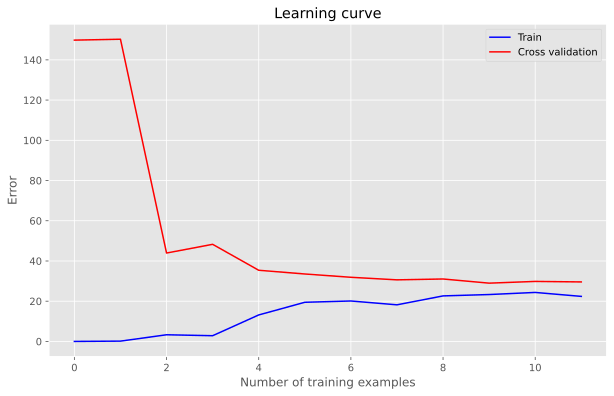

# Training Examples	Train Error		Cross Validation Error
	1		[0.00013189]		[149.81740953]
	2		[0.15308348]		[150.26139929]
	3		[3.31213067]		[43.95563449]
	4		[2.8431058]		[48.28751575]
	5		[13.17373024]		[35.38009591]
	6		[19.46230709]		[33.53394906]
	7		[20.10796289]		[31.89527881]
	8		[18.19952039]		[30.61920828]
	9		[22.63621149]		[31.04701872]
	10		[23.31631238]		[28.97825878]
	11		[24.36088354]		[29.83782093]
	12		[22.39731442]		[29.58544549]


In [406]:
result = learningCurve(X, y, Xval, yval, alpha, l, iterations,1)
error_train = result[0]
error_val = result[1]
m = len(error_train)
print('# Training Examples\tTrain Error\t\tCross Validation Error')
for i in range(m):
    print('\t{}\t\t{}\t\t{}'.format(i + 1, error_train[i], error_val[i]))

*The model is underfitting the data, and we have a chart with high bias. We need to use a complex model*

## 2.3)Polynomial regression

**2.3.2)Define Poly Features function**

In [407]:
def polyFeatures(X, p):
    # %POLYFEATURES Maps X (1D vector) into the p-th power
    # [X_poly] = POLYFEATURES(X, p) takes a data matrix X (size m x 1) and
    # maps each example into its polynomial features where
    # X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
    X_poly = np.zeros((np.size(X), p))
    m = X.shape[0]
    powers = np.tile(np.arange(1,p+1),(m,1))
    Xrep = np.tile(X,(1,p))
    Xpoly = X ** powers
    return Xpoly


**2.3.3)Define Polynomial plot function**

In [408]:
def polynomialPlot(X, y, Xval, yval, maxDegree , alpha, l, initial_theta, iterations, plotChart):
    #POLYNOMIALPLOT Generates the train and cross validation set errors for different polynomial degrees. 
    error_train = np.zeros((maxDegree,1))
    error_val = np.zeros((maxDegree,1)) 
    m = X.shape[0]
    
    for d in range(0, maxDegree):
        X_poly = polyFeatures(X, d)
        result = featureNormalize(X_poly)
        X_poly = result[0]
        mu = result[1]
        sigma = result[2]
        x0 = np.ones((m,1))
        X_poly = np.hstack((x0,X_poly))

        X_poly_val = polyFeatures(Xval, d)
        X_poly_val = X_poly_val - mu
        X_poly_val = X_poly_val / sigma
        x0 = np.ones((X_poly_val.shape[0],1))
        X_poly_val = np.hstack((x0,X_poly_val))

        initial_theta = np.zeros((X_poly_val.shape[1], 1))
        result = gradientDescent(X_poly, y, alpha, l, initial_theta, iterations)
        theta = result[0]
        error_train[d] = costFunction(X_poly, y, theta, l)
        error_val[d] = costFunction(X_poly_val, yval, theta, l)
    if plotChart == 1:
        polyDegrees = np.arange(0 , maxDegree)
        plt.figure(figsize=(10, 6))
        plt.title('Learning curve')
        plt.plot(polyDegrees, error_train, label='Train', color='blue')
        plt.plot(polyDegrees, error_val, label='Cross validation',color='red')
        plt.xlabel('Polynomial degree')
        plt.ylabel('Error')
        plt.ylim(top=25)
        plt.legend()
        plt.show()
    return error_train, error_val

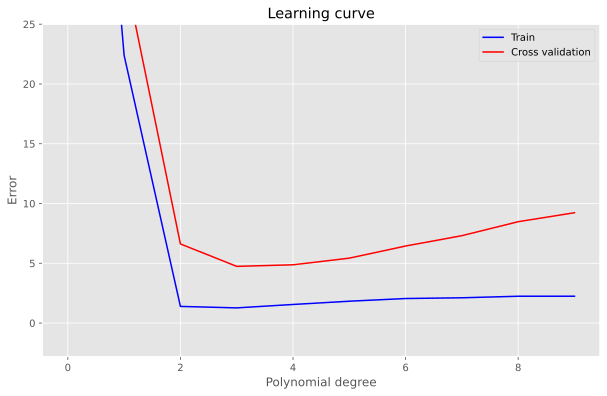

# Polynomial Degree	Train Error		Cross Validation Error
	0		[78.04867776]		[82.53099048]
	1		[22.39731442]		[29.58544549]
	2		[1.39426617]		[6.62023787]
	3		[1.27018848]		[4.74280511]
	4		[1.55540961]		[4.8750537]
	5		[1.8284941]		[5.43192759]
	6		[2.05295259]		[6.44561923]
	7		[2.11490281]		[7.31159018]
	8		[2.24353366]		[8.48001818]
	9		[2.24535912]		[9.2323305]


In [409]:
maxPol = 10
m = df_cv.shape[0]
n = df_cv.shape[1]-1
initial_theta = np.zeros((n+1,1))
result = polynomialPlot(Xorig, y, XvalOrig, yval, maxPol , alpha, l, initial_theta, iterations,1)
error_train = result[0]
error_val = result[1]

m = len(error_train)
print('# Polynomial Degree\tTrain Error\t\tCross Validation Error')
for i in range(m):
    print('\t{}\t\t{}\t\t{}'.format(i, error_train[i], error_val[i]))

# 3)Train of the chosen model

## 3.1)Model setting

*The best model seems to be polynomial regression whit degree of 5*

In [410]:
m = df_test.shape[0]
n = df_test.shape[1]-1
Xtest = df_test['x'].to_numpy().reshape(m,n)
X = np.copy(Xorig)
Xval = np.copy(XvalOrig)
d = 3

## 3.2)Preparing data whit features scaling

In [411]:
m = df_train.shape[0]
n = df_train.shape[1]-1

X_poly = polyFeatures(X, d)
result = featureNormalize(X_poly)
X_poly = result[0]
mu = result[1]
sigma = result[2]
x0 = np.ones((m,1))
X_poly = np.hstack((x0,X_poly))

X_poly_val = polyFeatures(Xval, d)
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val / sigma
x0 = np.ones((X_poly_val.shape[0],1))
X_poly_val = np.hstack((x0,X_poly_val))

X_poly_test = polyFeatures(Xtest, d)
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test / sigma
x0 = np.ones((X_poly_test.shape[0],1))
X_poly_test = np.hstack((x0,X_poly_test))



## 3.3)Automatic selection of alpha

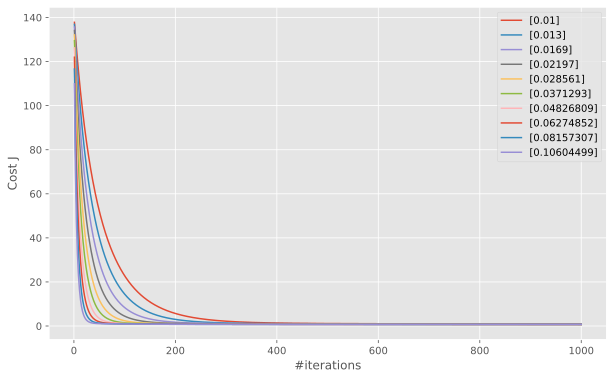

Alpha opt: 
 [[0.01      ]
 [0.013     ]
 [0.0169    ]
 [0.02197   ]
 [0.028561  ]
 [0.0371293 ]
 [0.04826809]
 [0.06274852]
 [0.08157307]
 [0.10604499]]
Best alpha:  [0.10604499]


In [412]:
iterations = 1000
l = 0
different_alpha = 10
alpha_possible = np.zeros((different_alpha,1))
alpha_possible[0] = 0.01
result = plotAlphaConvergence(iterations, different_alpha, alpha_possible, X_poly, y, l)
convergenceTest = result[0]
alpha_possible = result[1]
alpha_convergence = convergenceTest*alpha_possible
alpha_convergence = alpha_convergence[alpha_convergence != 0]
alpha_valid = np.copy(alpha_convergence).reshape(-1,1)
print('Alpha opt: \n', alpha_valid)
alpha = alpha_valid[-1]
print('Best alpha: ', alpha)

## 3.4)Train model

In [413]:
initial_theta = np.zeros((X_poly.shape[1], 1))
result = gradientDescent(X_poly, y, alpha, l, initial_theta, iterations)
theta = result[0]
theta

array([[11.21754167],
       [11.32998299],
       [ 7.6197401 ],
       [ 2.3974069 ]])

## 3.3)Plots learned polynomial regression fit over training set

**Define plot fit function**

In [414]:
def plotFit(min_x, max_x, mu, sigma, theta, p):
    #plots the learned polynomial fit with power p and feature normalization (mu, sigma).
    x = np.arange(min_x - 15 , max_x + 25 , 0.05).reshape(-1,1)

    X_poly = polyFeatures(x, p)
    X_poly = X_poly - mu
    X_poly = X_poly / sigma
    x0 = np.ones((X_poly.shape[0],1))
    X_poly = np.hstack((x0,X_poly))
    h = X_poly @ theta

    df_train.plot(kind='scatter', x='x', y='y', figsize=(10, 6), marker='x', color='red')
    plt.title('Polynomial Regression Fit (d = '+ str(p) + ')')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.plot(x, h, linestyle='--', color='blue')

    plt.show()

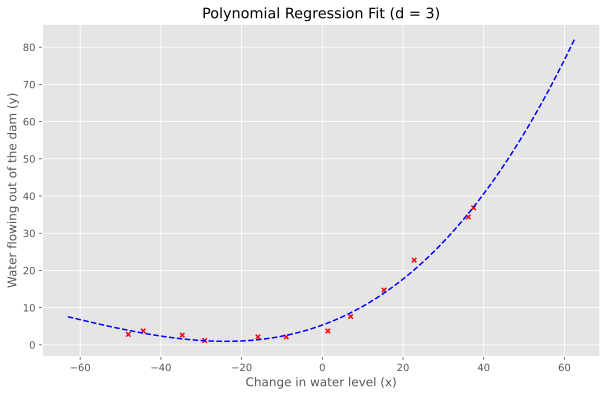

In [415]:
max_x = np.max(X,0)
min_x = np.min(X,0)
plotFit(min_x, max_x, mu, sigma, theta, d)

# 4.Lambda selection

**4.1)Define validation curve method**

In [416]:
def validationCurve(X, y, Xval, yval, alpha, iterations,plotChart):
    #VALIDATIONCURVE Generate the train and validation errors needed to
    #plot a validation curve that we can use to select lambda
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]).reshape(-1,1)

    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))

    for i in range(0,len(lambda_vec)):
        l = lambda_vec[i]
        initial_theta = np.zeros((X.shape[1], 1))
        result = gradientDescent(X, y, alpha, l, initial_theta, iterations)
        theta = result[0]
        error_train[i] = costFunction(X, y, theta, l)
        error_val[i] = costFunction(Xval, yval, theta, l)
    if plotChart == 1:
        plt.figure(figsize=(10, 6))
        plt.title('Validation curve')
        plt.plot(lambda_vec, error_train, label='Train', color='blue')
        plt.plot(lambda_vec, error_val, label='Cross validation',color='red')
        plt.xlabel('Lambda')
        plt.ylabel('Error')
        plt.legend()
        plt.show()
    return lambda_vec, error_train, error_val
    

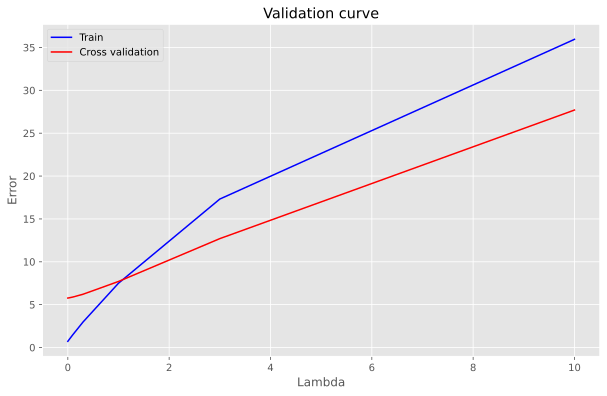

# 	lambda		Train Error		Cross Validation Error
	[0.]		[0.71624386]		[5.76626281]
	[0.001]		[0.7242525]		[5.7672662]
	[0.003]		[0.74025755]		[5.76928741]
	[0.01]		[0.79614805]		[5.77651063]
	[0.03]		[0.95477257]		[5.79836683]
	[0.1]		[1.49850752]		[5.88711334]
	[0.3]		[2.97137122]		[6.21220205]
	[1.]		[7.49804716]		[7.70362345]
	[3.]		[17.31853015]		[12.70155111]
	[10.]		[35.95091034]		[27.70186196]


In [417]:
result = validationCurve(X_poly, y, X_poly_val, yval, alpha, iterations,1)
lambda_vec = result[0]
error_train = result[1]
error_val = result[2]
m = len(lambda_vec)
print('# \tlambda\t\tTrain Error\t\tCross Validation Error')
for i in range(m):
    print('\t{}\t\t{}\t\t{}'.format(lambda_vec[i], error_train[i], error_val[i]))


# 5)Train definitive model

**5.1)Define learning parameters**

In [418]:
alpha = 0.10604499 #best alpha
iterations = 1000   
l = 0.001 #best lambda

**5.2)Training**

In [419]:
result = gradientDescent(X_poly, y, alpha, l, initial_theta, iterations)
theta = result[0]

**5.3)Plot learning curve**

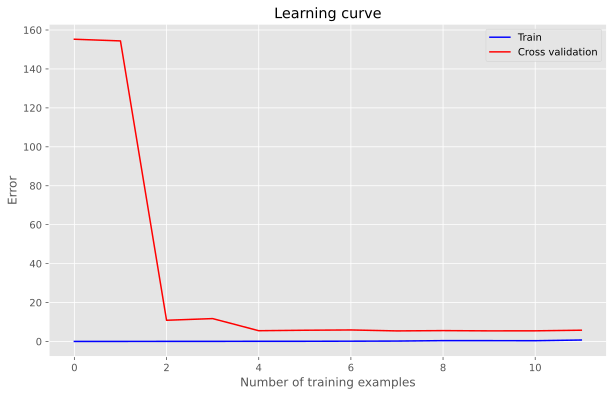

# Training Examples	Train Error	Cross Validation Error
	1		[0.00050019]		[155.24520317]
	2		[0.00036369]		[154.38147219]
	3		[0.02768613]		[10.86995701]
	4		[0.02637397]		[11.73143456]
	5		[0.07204881]		[5.50280346]
	6		[0.07360772]		[5.74482802]
	7		[0.12146469]		[5.89201123]
	8		[0.18543941]		[5.40313548]
	9		[0.41189806]		[5.55839941]
	10		[0.40102883]		[5.42611876]
	11		[0.36789819]		[5.44786861]
	12		[0.7242525]		[5.7672662]


In [420]:
result = learningCurve(X_poly, y, X_poly_val, yval, alpha, l, iterations,1)
error_train = result[0]
error_val = result[1]
m = len(error_train)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('\t{}\t\t{}\t\t{}'.format(i + 1, error_train[i], error_val[i]))

**5.4)Compute the test error**

In [421]:
m = df_test.shape[0]
ytest = df_test['y'].to_numpy().reshape(m,1)
error_test = costFunction(X_poly_test, ytest, theta, l)
print("Test error: {:.4f}".format(error_test))

Test error: 5.4963
